<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=b35cc8e890ddf58f6de610c99f9d193ff199e6a57e15fd07c4420ddbd85b160a
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [135]:
import timm
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import ast
import os

In [221]:
model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(model_name, pretrained=True)
model.eval()
model = model.to(device)

In [222]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [223]:
size_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dir = 'cat/'

images = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_resized = size_transform(image)
        images.append(image_resized)

if image_resized:
    input_tensor = torch.stack([norm_transform(img) for img in images])
    print(f"Input tensor shape: {input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")

Input tensor shape: torch.Size([8, 3, 224, 224])


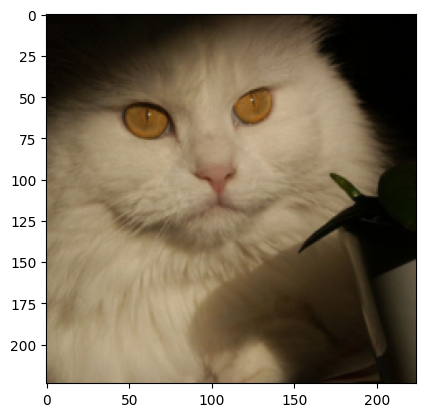

Predicted class: 283


In [224]:
model.eval()

input_tensor = input_tensor.to(device)

output = model(input_tensor[4].unsqueeze(0))

_, predicted_class = torch.max(output, 1)

plt.imshow(images[4])
plt.show()

print(f"Predicted class: {predicted_class.item()}")

torch.Size([1, 512, 7, 7])
torch.Size([512, 7, 7])
torch.Size([512])

Feature Map Max Weights: 0.02386908046901226
Feature Map Min Weights: -0.03176585212349892

Feature Map Mean Weights: -0.0009269419824704528
Feature Map Std Weights: 0.005583255551755428

Top 5 feature maps and their weights:
1. Feature Map 252: Weight = 0.0239
2. Feature Map 72: Weight = 0.0227
3. Feature Map 108: Weight = 0.0218
4. Feature Map 388: Weight = 0.0177
5. Feature Map 391: Weight = 0.0173

Feature Map Weights graph


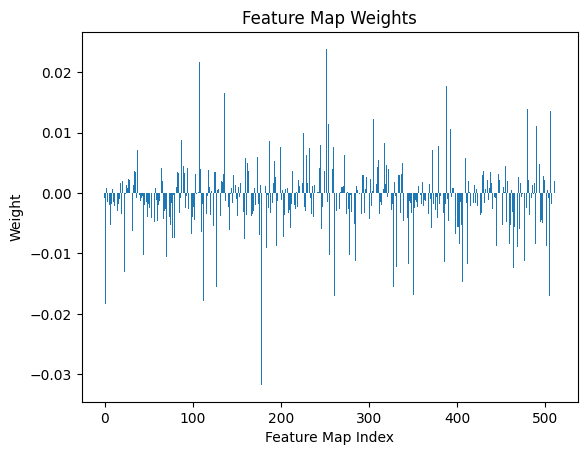

In [225]:
# 기울기 Hook 설정
gradients = []
def save_gradients(module, grad_in, grad_out):
  gradients.append(grad_out[0])

target_layer = model.layer4[-1]
target_class = 283

# Hook 등록
hook = target_layer.register_full_backward_hook(save_gradients)

output = model(input_tensor[4].unsqueeze(0))

# 순전파 및 역전파
model.zero_grad()
output[0, target_class].backward(retain_graph=True)

# Hook을 통해 기울기 저장
hook.remove()

# print(gradients)
print(gradients[0].shape)

# gradients 리스트에 저장된 기울기 텐서 추출
gradient = gradients[0][0].detach()  # [C, H, W]

print(gradient.shape)

# 가중치 계산 (C,)
grad_weights = torch.mean(gradient, dim=(1, 2))  # 각 feature map의 전역 평균
print(grad_weights.shape)

# 가중치를 NumPy 배열로 변환
grad_weights = grad_weights.cpu().numpy()

# 각 feature map과 가중치 출력
# print("Feature Map Weights:")
# for idx, weight in enumerate(grad_weights):
#     print(f"Feature Map {idx}: Weight = {weight}")

print(f"\nFeature Map Max Weights: {np.max(grad_weights)}")
print(f"Feature Map Min Weights: {np.min(grad_weights)}")

print(f"\nFeature Map Mean Weights: {np.mean(grad_weights)}")
print(f"Feature Map Std Weights: {np.std(grad_weights)}")

# 상위 n개의 값을 선택
n = 5  # 원하는 상위 n개 값으로 설정

# 상위 n개의 인덱스 찾기 (내림차순)
top_n_indices = np.argsort(grad_weights)[-n:][::-1]
top_n_values = grad_weights[top_n_indices]

# 결과 출력
print(f"\nTop {n} feature maps and their weights:")
for rank, (idx, value) in enumerate(zip(top_n_indices, top_n_values), start=1):
    print(f"{rank}. Feature Map {idx}: Weight = {value:.4f}")

print("\nFeature Map Weights graph")
plt.bar(range(len(grad_weights)), grad_weights)
plt.xlabel("Feature Map Index")
plt.ylabel("Weight")
plt.title("Feature Map Weights")
plt.show()

torch.Size([1, 512, 7, 7])
(512, 7, 7)
(512, 1, 1)
(512, 7, 7)
(7, 7)


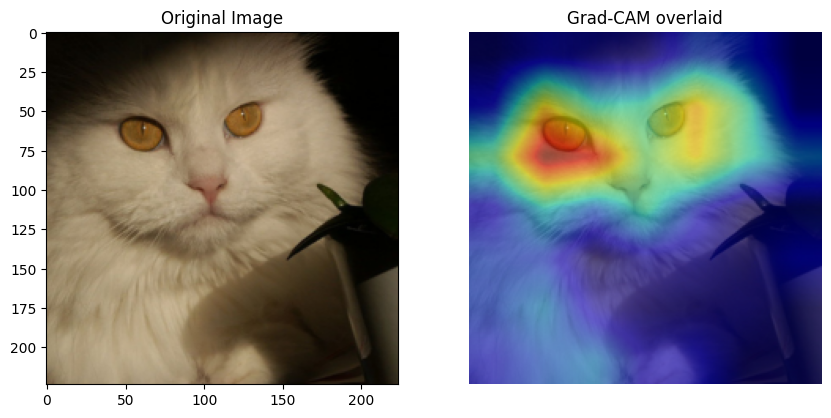

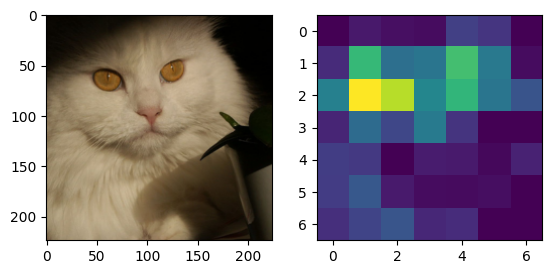

In [231]:
import cv2

def forward_hook(module, input, output):
    features.append(output.detach())

target_layer = model.layer4[-1]

features = []

hook_handle = target_layer.register_forward_hook(forward_hook)

with torch.no_grad():
    output = model(input_tensor[4].unsqueeze(0))

hook_handle.remove()

print(features[0].shape)

features = features[0][0].detach().cpu().numpy()
print(features.shape)

grad_weights = grad_weights.reshape(512, 1, 1)
print(grad_weights.shape)

grad_cam = np.multiply(features, grad_weights)
print(grad_cam.shape)

grad_cam = np.sum(grad_cam, axis=0)
print(grad_cam.shape)

grad_cam = np.maximum(grad_cam, 0)

grad_cam_resized = cv2.resize(grad_cam, (224, 224), interpolation=cv2.INTER_LINEAR)
grad_cam_blurred = cv2.GaussianBlur(grad_cam_resized, (11, 11), 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(images[4])

plt.subplot(1, 2, 2)
plt.title("Grad-CAM overlaid")
plt.imshow(images[4])
plt.imshow(grad_cam_blurred, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(images[4])

plt.subplot(1, 2, 2)
plt.imshow(grad_cam)
plt.show()

grad_weights = grad_weights.reshape(512)

(512,)

Feature Map Max Weights: 1.1695849895477295
Feature Map Min Weights: -1.556526780128479

Feature Map Mean Weights: -0.04542015865445137
Feature Map Std Weights: 0.27357950806617737

Top 5 feature maps and their weights:
1. Feature Map 252: Weight = 1.1696
2. Feature Map 72: Weight = 1.1137
3. Feature Map 108: Weight = 1.0668
4. Feature Map 388: Weight = 0.8654
5. Feature Map 391: Weight = 0.8453
127: -0.761776864528656
244: 0.19999419152736664

GAP Weights graph


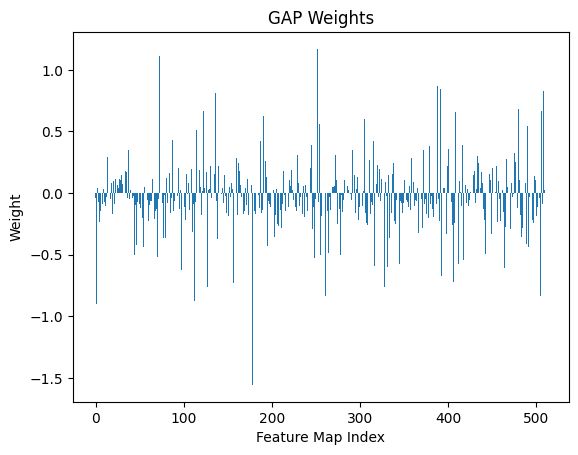

In [228]:
target_class = 283

gap_weights = model.fc.weight[target_class]
gap_weights = gap_weights.detach().cpu().numpy()
print(gap_weights.shape)

print(f"\nFeature Map Max Weights: {np.max(gap_weights)}")
print(f"Feature Map Min Weights: {np.min(gap_weights)}")

print(f"\nFeature Map Mean Weights: {np.mean(gap_weights)}")
print(f"Feature Map Std Weights: {np.std(gap_weights)}")

# 상위 n개의 값을 선택
n = 5  # 원하는 상위 n개 값으로 설정

# 상위 n개의 인덱스 찾기 (내림차순)
top_n_indices = np.argsort(gap_weights)[-n:][::-1]
top_n_values = gap_weights[top_n_indices]

# 결과 출력
print(f"\nTop {n} feature maps and their weights:")
for rank, (idx, value) in enumerate(zip(top_n_indices, top_n_values), start=1):
    print(f"{rank}. Feature Map {idx}: Weight = {value:.4f}")

print(f"127: {gap_weights[127]}")
print(f"244: {gap_weights[244]}")

print("\nGAP Weights graph")
plt.bar(range(len(gap_weights)), gap_weights)
plt.xlabel("Feature Map Index")
plt.ylabel("Weight")
plt.title("GAP Weights")
plt.show()

In [229]:
target_layer = model.global_pool

# 특징 맵을 저장할 리스트
features = []

def forward_hook(module, input, output):
    features.append(output.detach())

# 후킹 등록
hook_handle = target_layer.register_forward_hook(forward_hook)

# 4. 순전파 수행하여 특징 맵 추출
with torch.no_grad():
    output = model(input_tensor[4].unsqueeze(0))

# 후킹 해제
hook_handle.remove()

print(features[0].shape)

gap_outputs = features[0][0]
gap_outputs = gap_outputs.detach().cpu().numpy()

print(gap_outputs.shape)

fc_weights = model.fc.weight[target_class]
fc_weights = fc_weights.detach().cpu().numpy()
print(fc_weights.shape)

target_class = 283

fc_bias = model.fc.bias[target_class]
fc_bias = fc_bias.detach().cpu().numpy()
print(fc_bias)

y_c = np.dot(gap_outputs, fc_weights) + fc_bias
print(y_c)

contributions = np.multiply(gap_outputs, fc_weights)
print(contributions.shape)

print(f"\nFeature Map Max value: {np.max(gap_outputs)}")
print(f"Feature Map Min value: {np.min(gap_outputs)}")

print(f"\nFeature Map Mean value: {np.mean(gap_outputs)}")
print(f"Feature Map Std value: {np.std(gap_outputs)}")

# 상위 n개의 값을 선택
n = 5  # 원하는 상위 n개 값으로 설정

# 상위 n개의 인덱스 찾기 (내림차순)
top_n_indices = np.argsort(gap_outputs)[-n:][::-1]
top_n_values = gap_outputs[top_n_indices]

# 결과 출력
print(f"\nTop {n} feature maps and their values:")
for rank, (idx, value) in enumerate(zip(top_n_indices, top_n_values), start=1):
    print(f"{rank}. Feature Map {idx}: value = {value:.4f}")

target_feature = 244
print()
print(gap_outputs[target_feature])
print(fc_weights[target_feature])
print(contributions[target_feature])

torch.Size([1, 512])
(512,)
(512,)
-3.3126915
3.430032
(512,)

Feature Map Max value: 2.454033374786377
Feature Map Min value: 0.0

Feature Map Mean value: 0.18511269986629486
Feature Map Std value: 0.2970711290836334

Top 5 feature maps and their values:
1. Feature Map 108: value = 2.4540
2. Feature Map 112: value = 2.2301
3. Feature Map 380: value = 1.8528
4. Feature Map 508: value = 1.6719
5. Feature Map 506: value = 1.6147

0.15452085
0.19999419
0.030903274


In [232]:
import pandas as pd

df = pd.DataFrame({
    'grad_cam_weight': grad_weights,
    'cam_weight': gap_weights,
    'feature_map_value': gap_outputs
})

corr_matrix = df.corr()

print(corr_matrix)

                   grad_cam_weight  cam_weight  feature_map_value
grad_cam_weight           1.000000    1.000000           0.265492
cam_weight                1.000000    1.000000           0.265492
feature_map_value         0.265492    0.265492           1.000000


In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]

target_layers = [model.layer4[-1]]
targets = [ClassifierOutputTarget(283) for _ in range(input_tensor.shape[0])]

rgb_img = input_tensor.cpu().numpy().copy()

# print(rgb_img.shape)
for b in range(rgb_img.shape[0]):
  for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
    rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

rgb_img = rgb_img.transpose(0, 2, 3, 1)

# print(rgb_img.shape)


# Construct the CAM object once, and then re-use it on many   images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
  # In this example grayscale_cam has only one image in the batch:
  #grayscale_cam = grayscale_cam[0, :]
  print(grayscale_cam.shape)
  #visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  visualizations = []
  for i in range(grayscale_cam.shape[0]):
    grayscale_cam_img = grayscale_cam[i]
    visualization = show_cam_on_image(rgb_img[i], grayscale_cam_img, use_rgb=True)
    visualizations.append(visualization)
  model_outputs = cam.outputs

visualizations = np.stack(visualizations)
# print(visualizations.shape)

(8, 224, 224)


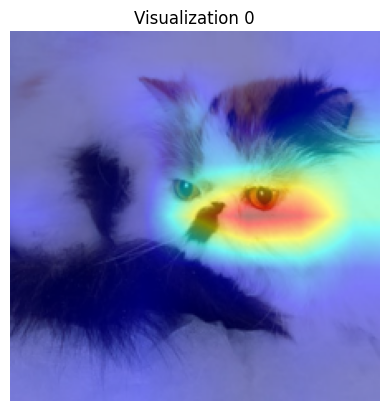

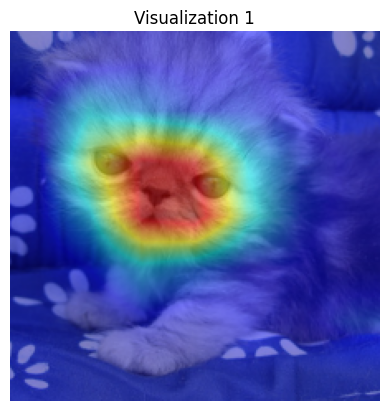

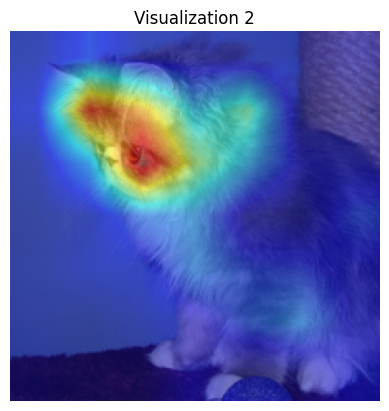

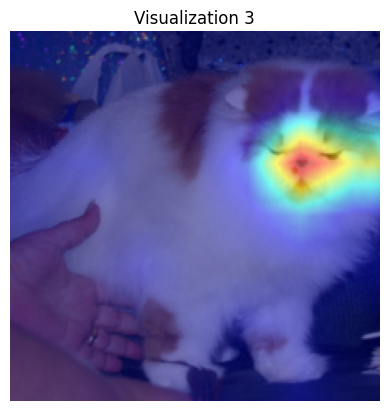

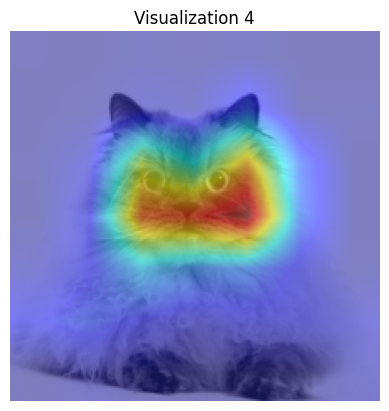

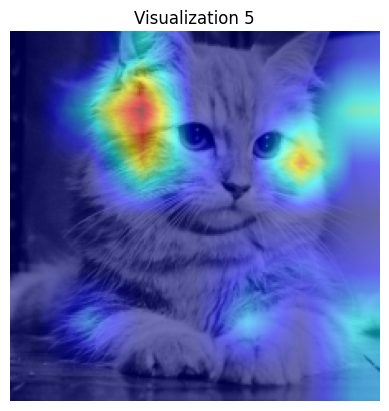

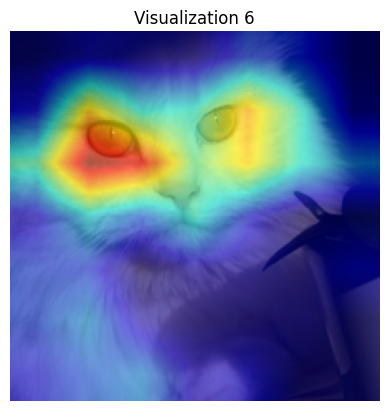

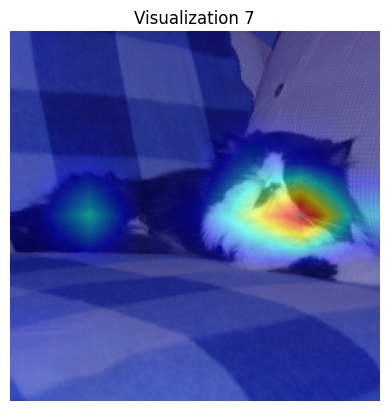

In [ ]:
# plt.imshow(visualization)
# plt.show()

# print(model_outputs)

# Display all visualizations using matplotlib
for idx, vis in enumerate(visualizations):
    plt.imshow(vis)
    plt.title(f"Visualization {idx}")
    plt.axis("off")
    plt.show()